#### Imports

In [1]:
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io

import numpy as np
from scipy.signal import find_peaks

from cellpose.utils import masks_to_outlines
from cellpose.plot import image_to_rgb



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.5.dev16+g79b0fcb 
platform:       	linux 
python version: 	3.12.9 
torch version:  	2.7.1+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [2]:
sys.path.append("..")

In [3]:
from src.model import MS2

#### Functions

In [4]:
def enhance_cell_image_contrast(image):
    if image.shape[0] < 4:
        image = np.transpose(image, (1, 2, 0))
    if image.shape[-1] < 3 or image.ndim < 3:
        image = image_to_rgb(image, channels=[0, 0])
    else:
        if image.max() <= 50.0:
            image = np.uint8(np.clip(image, 0, 1) * 255)
    return image

#### Inputs

In [5]:
czi_file_path = '/home/dafei/data/MS2/New-03_I.czi'
device = torch.device('cuda:0')

In [6]:
ms2 = MS2(czi_path = czi_file_path, device=device)

Successfully loaded /home/dafei/data/MS2/New-03_I.czi
data shape: (1, 64, 2, 100, 1024, 624, 1)


In [7]:
cells_z_projection = ms2.get_cells_z_projection(method='mean')
ms2_z_projection = ms2.get_ms2_z_projection(method='max')

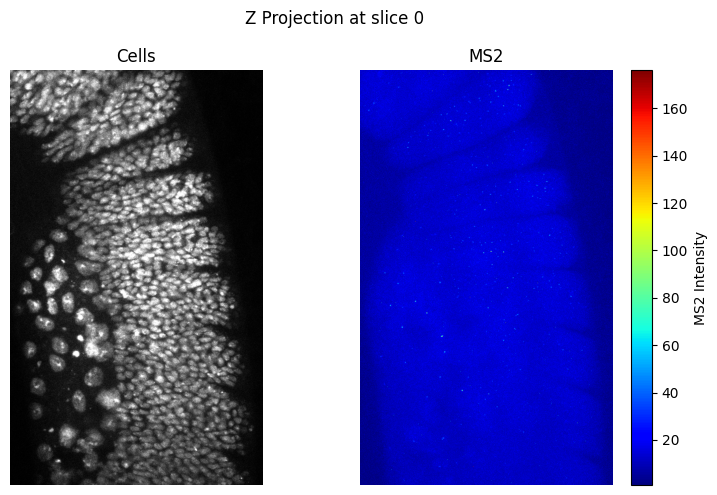

In [8]:
z = 0
cell_image = enhance_cell_image_contrast(cells_z_projection[z])
ms2_image = enhance_cell_image_contrast(ms2_z_projection[z])
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(cell_image, cmap='gray')
ax[0].set_title('Cells')
ax[0].axis('off')
img1 = ax[1].imshow(ms2_z_projection[z], cmap='jet')
cbr = plt.colorbar(img1, ax=ax[1], orientation='vertical')
cbr.set_label('MS2 Intensity')
ax[1].set_title('MS2')
ax[1].axis('off')
plt.suptitle(f'Z Projection at slice {z}')
plt.tight_layout()
plt.show()

In [9]:
mask, flows, styles = ms2.segment_cells(cells_z_projection[z])

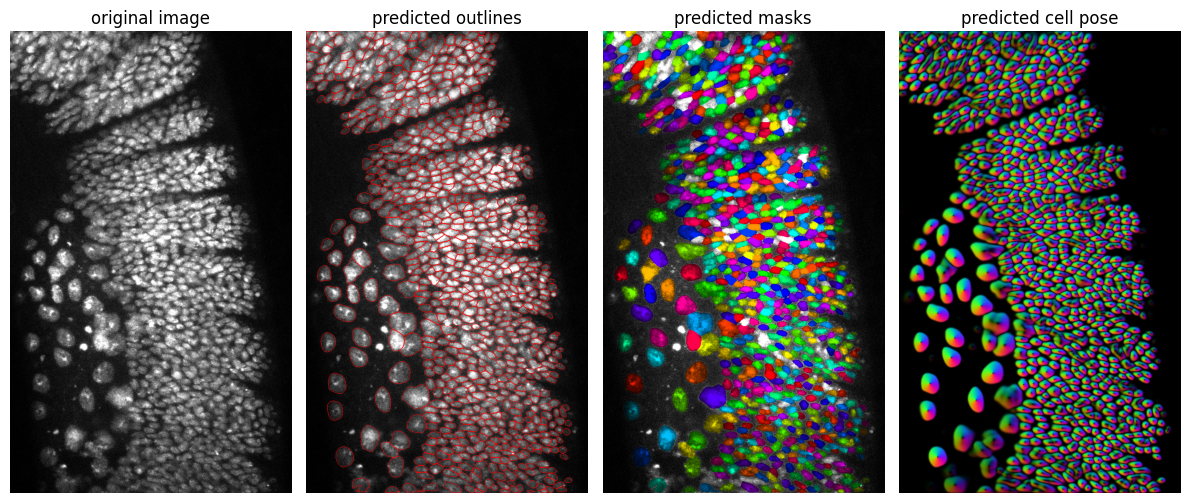

In [10]:
ms2.plot_cell_segmentation(cells_z_projection[z], mask, flows)

In [13]:
ms2_z_projection[z].max()

np.uint8(176)

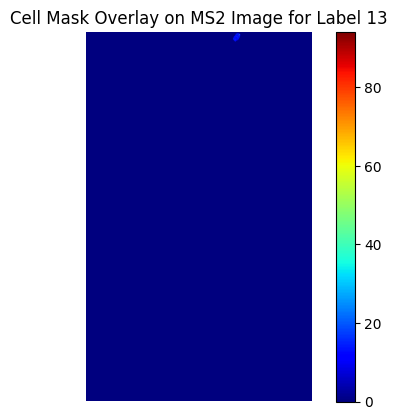

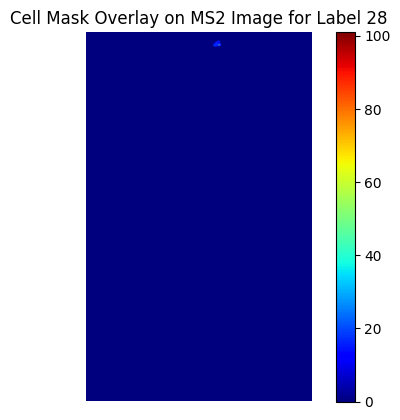

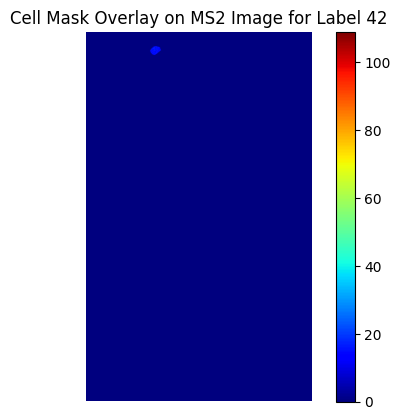

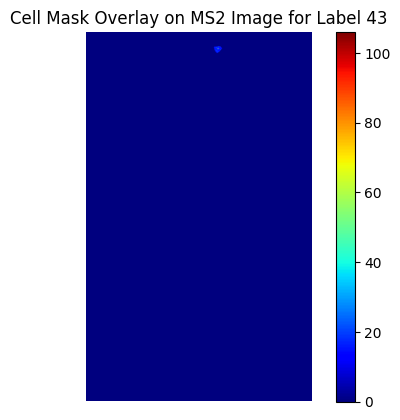

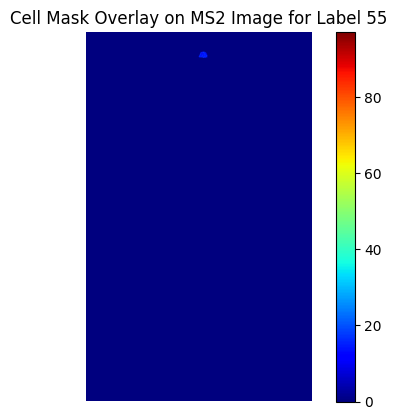

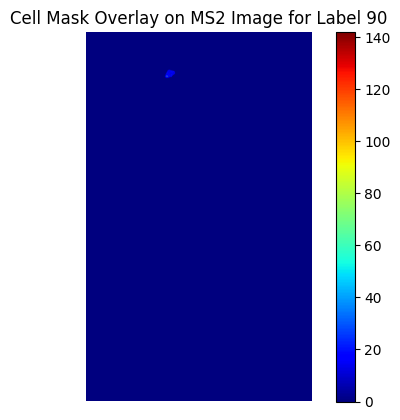

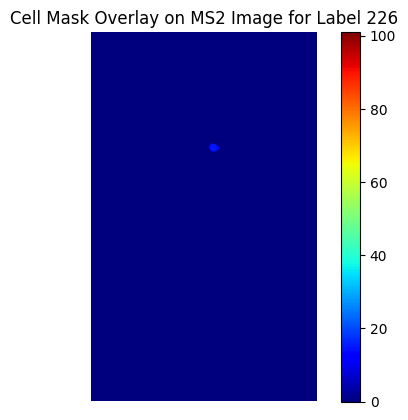

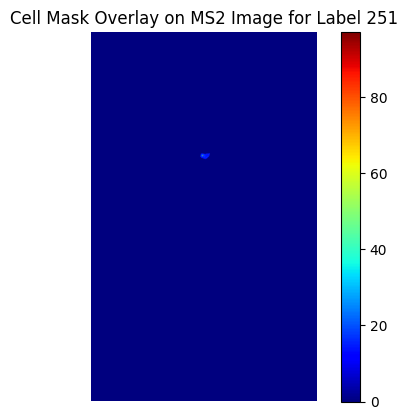

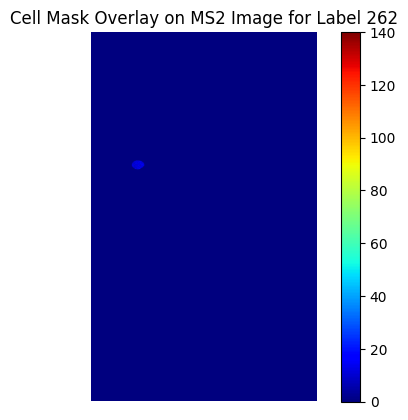

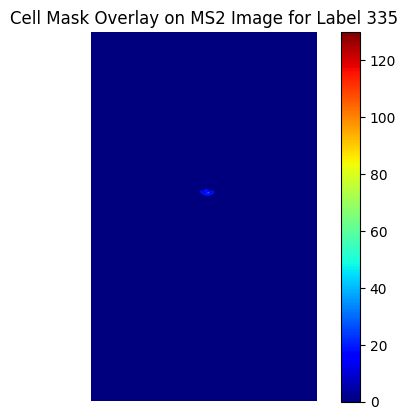

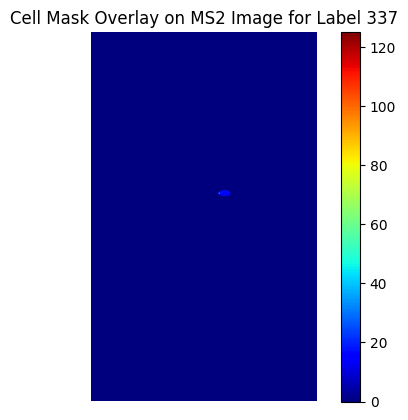

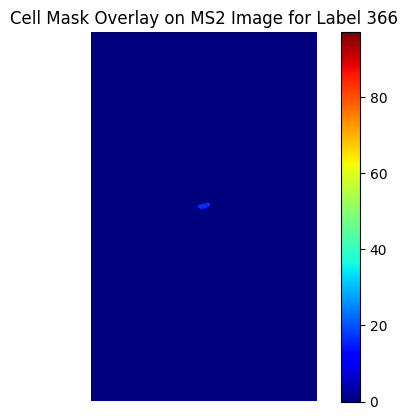

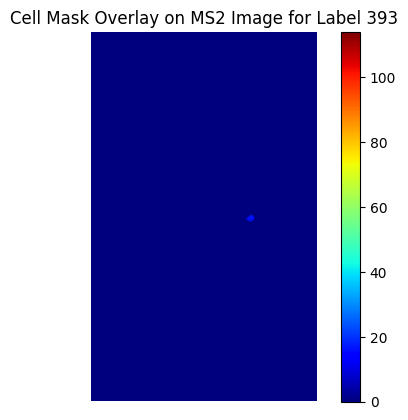

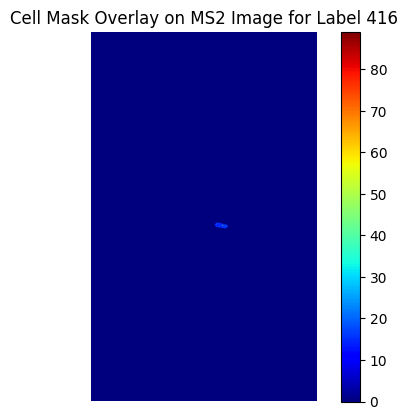

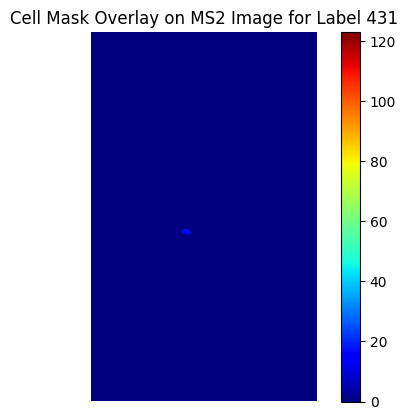

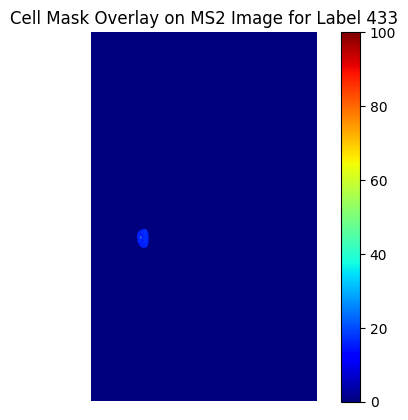

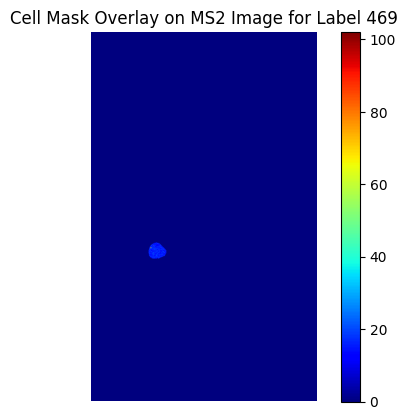

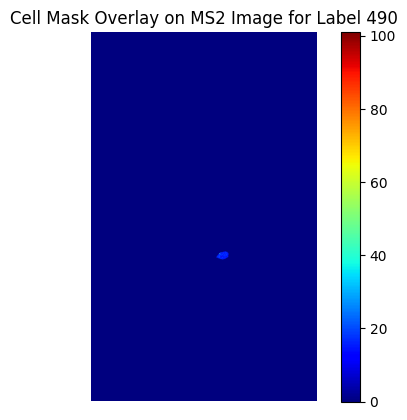

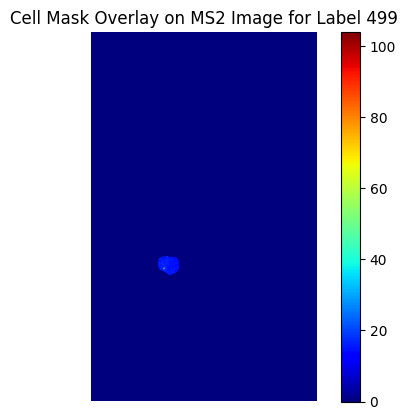

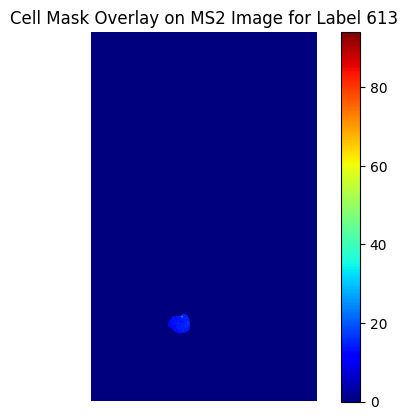

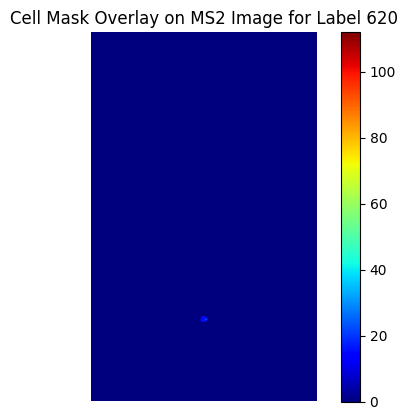

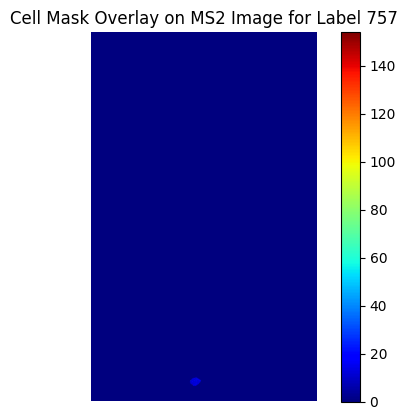

In [14]:
max_label = int(mask.max())
th = ms2_z_projection[z].max()/2
for label in range(1, max_label):
    cell_mask = (mask == label).astype(np.uint8)
    cell_intensity_image = cell_mask*ms2_z_projection[z]
    intensity_in_cell_area = cell_intensity_image[cell_mask > 0]
    max_intensity = intensity_in_cell_area.max()
    if max_intensity > th:
        plt.imshow(cell_intensity_image, cmap='jet')
        plt.title(f'Cell Mask Overlay on MS2 Image for Label {label}')
        plt.colorbar()
        plt.axis('off')
        plt.show()
    